# Integrating Defeasible Deontic Logic with Neuro-Symbolic AI for Legal Concept Drift Detection

**Osama Moftah**  
Msc Data Science, AI, and Digital Business    
GISMA University of Applied Sciences  
September 2025

**Research Question**: How can defeasible deontic logic be integrated into neuro-symbolic AI to enable explainable and auditable legal concept drift detection across jurisdictions?


In [1]:
import warnings
warnings.filterwarnings('ignore')

import logging
import math
import re
import json
import hashlib
from datetime import date, datetime
from dataclasses import dataclass, field
from enum import Enum
from typing import Dict, List, Optional, Tuple, Any

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ks_2samp, mannwhitneyu
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(levelname)s:%(name)s:%(message)s")
log = logging.getLogger("NSAI")

# Configuration system
@dataclass(frozen=True)
class Config:
    seed: int = 50
    use_legal_bert: bool = True
    use_real_data: bool = True
    guaranteed_drift: bool = False
    permutations: int = 200
    batch_size: int = 8
    max_docs: int = 100
    emb_dim: int = 384
    drift_threshold: float = 0.05
    stream_size: int = 50

CFG = Config()
rng = np.random.default_rng(CFG.seed)

log.info("System initialized seed=%d, legal_bert=%s", CFG.seed, CFG.use_legal_bert)
print(f"System {CFG.max_docs} docs, batch={CFG.batch_size}, Legal-BERT={CFG.use_legal_bert}")

INFO:NSAI:System initialized seed=50, legal_bert=True


System 100 docs, batch=8, Legal-BERT=True


**Legal-BERT setup**

In [2]:
try:
    from sentence_transformers import SentenceTransformer
    log.info("Sentence Transformers working")
except ImportError:
    log.info("Installing sentence-transformers")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sentence-transformers"])
    from sentence_transformers import SentenceTransformer
    log.info("SentenceTransformers installed")

print("Legal-BERT dependencies ready for nlpaueb/legal-bert-base-uncased")

INFO:NSAI:Sentence Transformers working


Legal-BERT dependencies ready for nlpaueb/legal-bert-base-uncased


**Data Structure**

In [3]:
class DeonticOperator(Enum):
    OBLIGATION = "O"
    PERMISSION = "P"
    PROHIBITION = "F"

class SourceReliability(Enum):
    HIGH = "high"
    MEDIUM = "medium"
    LOW = "low"

@dataclass
class LegalDocument:
    text: str
    document_id: str
    jurisdiction: str
    source_reliability: SourceReliability
    metadata: Dict[str, Any] = field(default_factory=dict)

@dataclass
class DDLRule:
    rule_id: str
    deontic_operator: DeonticOperator
    condition: str
    action: str
    priority: int
    specificity_level: int
    legal_citation: str
    framework: str
    temporal_validity: Tuple[Optional[str], Optional[str]]
    applicable_jurisdictions: List[str]

@dataclass
class InterventionMetrics:
    total_decisions: int = 0
    nsai_interventions: int = 0
    blocks: int = 0
    obligations: int = 0
    allows: int = 0

log.info("Data structures ready")

INFO:NSAI:Data structures ready


**Embedding engine**

In [4]:
 class EmbeddingEngine:
    def __init__(self, use_legal_bert: bool = True, *, rng: Optional[np.random.Generator] = None):
        self.use_legal_bert = use_legal_bert
        self.rng = rng or np.random.default_rng()
        self.legal_terms = {
            'gdpr', 'privacy', 'consent', 'data', 'protection', 'automated',
            'decision', 'transparency', 'obligation', 'ai', 'high_risk'
        }

        # Initialize Legal-BERT model (if enabled)
        self.model = None
        if self.use_legal_bert:
            try:
                log.info("Loading Legal-BERT model: nlpaueb/legal-bert-base-uncased")
                self.model = SentenceTransformer('nlpaueb/legal-bert-base-uncased')
                log.info("Legal-BERT model loaded.")
            except Exception as e:
                log.warning("Failed to load Legal-BERT: %s, falling back to hash encoding", e)
                self.use_legal_bert = False
                self.model = None

    def encode_texts(self, texts: List[str]) -> np.ndarray:
        if self.use_legal_bert and self.model is not None:
            return self._legal_bert_encode(texts)
        return self._hash_encode(texts)

    # Fall back to hash embedding if Legal-BERT loading failed
    def _hash_encode(self, texts: List[str]) -> np.ndarray:
        embeddings = np.zeros((len(texts), CFG.emb_dim), dtype=np.float32)

        for i, text in enumerate(texts):
            words = set(text.lower().split())

            for word in words:
                h = int(hashlib.md5(word.encode()).hexdigest(), 16) % CFG.emb_dim
                weight = 5.0 if word in self.legal_terms else 1.0
                embeddings[i, h] += weight

            noise = self.rng.normal(0, 0.1, CFG.emb_dim)
            embeddings[i] += noise

        return embeddings

    def _legal_bert_encode(self, texts: List[str]) -> np.ndarray:
        try:
            log.info("Encoding %d texts with Legal-BERT", len(texts))

            # Clean texts and handle edge cases
            cleaned_texts = []
            for text in texts:
                if isinstance(text, str) and text.strip():
                    cleaned_texts.append(text.strip())
                else:
                    cleaned_texts.append("empty document")

            # Generate embeddings with memory management
            embeddings = self.model.encode(
                cleaned_texts,
                batch_size=CFG.batch_size,
                show_progress_bar=len(texts) > 50,
                convert_to_numpy=True,
                normalize_embeddings=True
            )

            log.info("Legal-BERT encoding complete: shape=%s", embeddings.shape)
            return embeddings.astype(np.float32)

        except Exception as e:
            log.error("Legal-BERT encoding failed: %s, falling back to hash encoding", e)
            return self._hash_encode(texts)

log.info("EmbeddingEngine ready")

INFO:NSAI:EmbeddingEngine ready


**Legal concept extraction**

In [5]:
class LegalConceptExtractor:
    def __init__(self):
        self.patterns = {
            'automated_decision': [
                r'automated.{0,20}decision',
                r'algorithmic.{0,20}decision',
                r'automatic.{0,20}processing',
                r'ai.{0,20}decision',
                r'automated.{0,20}system'
            ],
            'dpo_reference': [
                r'data protection officer',
                r'\\bDPO\\b'
            ],
            'high_risk': [
                r'high.{0,10}risk',
                r'critical.{0,10}system',
                r'high.{0,10}risk.{0,10}ai',
                r'conformity.{0,10}assessment'
            ],
            'transparency': [
                r'transparency',
                r'explainability',
                r'explainable.{0,10}ai',
                r'transparency.{0,10}requirement',
                r'ai.{0,10}transparency'
            ],
            'data_protection': [
                r'data protection',
                r'privacy',
                r'GDPR',
                r'personal.{0,10}data'
            ],
            'ai_system': [
                r'ai.{0,10}system',
                r'artificial.{0,10}intelligence',
                r'machine.{0,10}learning',
                r'algorithmic.{0,10}system'
            ],
            'bias_monitoring': [
                r'bias.{0,10}monitoring',
                r'algorithmic.{0,10}bias',
                r'fairness.{0,10}assessment',
                r'bias.{0,10}detection'
            ],
            'human_oversight': [
                r'human.{0,10}oversight',
                r'human.{0,10}supervision',
                r'human.{0,10}control',
                r'meaningful.{0,10}human.{0,10}control'
            ]
        }

    def extract_concepts(self, documents: List[LegalDocument]) -> List[str]:
        extracted = []

        for doc in documents:
            text = doc.text.lower()
            for concept, pattern_list in self.patterns.items():
                for pattern in pattern_list:
                    if re.search(pattern, text, re.IGNORECASE):
                        extracted.append(concept)
                        break

        unique_concepts = list(set(extracted))
        log.info("Extracted concepts: %s (from %d docs)", unique_concepts, len(documents))
        return unique_concepts

log.info("LegalConceptExtractor ready")

INFO:NSAI:LegalConceptExtractor ready


**Drift Detection Function**

In [6]:
# Multi-method statistical drift detection - most complex component to get right
class StatisticalDriftDetector:
    def __init__(self, *, rng: Optional[np.random.Generator] = None):
        self.rng = rng or np.random.default_rng()

    def detect_drift(self, baseline: np.ndarray, current: np.ndarray, n_perms: int = 200) -> Dict[str, Any]:
        log.info("Running drift detection: baseline=%s, current=%s", baseline.shape, current.shape)

        # PCA for dimensionality reduction
        pca = PCA(n_components=min(10, baseline.shape[1]))
        base_pca = pca.fit_transform(baseline)
        curr_pca = pca.transform(current)

        # Standard statistical tests
        ks_stat, ks_p = ks_2samp(base_pca[:, 0], curr_pca[:, 0])
        mw_stat, mw_p = mannwhitneyu(base_pca[:, 0], curr_pca[:, 0], alternative='two-sided')

        # Advanced multivariate tests with permutation testing
        mmd_p = self._permutation_test(baseline, current, self._compute_mmd, n_perms)
        energy_p = self._permutation_test(baseline, current, self._compute_energy, n_perms)

        # Fisher's method for combining p-values
        p_values = [ks_p, mw_p, mmd_p, energy_p]
        combined_stat, combined_p = self._fisher_combine(p_values)

        # Always compute severity and confidence measures
        wasserstein_severity = self._compute_wasserstein_distance(base_pca[:, 0], curr_pca[:, 0])
        confidence = max(0.001, min(0.999, 1.0 - combined_p))
        cohens_d = self._compute_cohens_d(base_pca[:, 0], curr_pca[:, 0])

        drift_detected = bool(combined_p < CFG.drift_threshold)

        result = {
            'drift_detected': drift_detected,
            'p_value': float(combined_p),
            'confidence': float(confidence),
            'severity': float(wasserstein_severity),
            'effect_size': float(cohens_d),
            'threshold_used': float(CFG.drift_threshold),
            'statistical_tests': {
                'ks_test': {'statistic': float(ks_stat), 'p_value': float(ks_p)},
                'mannwhitney': {'statistic': float(mw_stat), 'p_value': float(mw_p)},
                'mmd': {'p_value': float(mmd_p)},
                'energy': {'p_value': float(energy_p)}
            },
            'combined_statistic': float(combined_stat),
            'baseline_size': int(baseline.shape[0]),
            'current_size': int(current.shape[0]),
            'pca_explained_variance': float(pca.explained_variance_ratio_[0]) if len(pca.explained_variance_ratio_) > 0 else 0.0
        }

        log.info("Drift detection complete: drift=%s, p=%.6f, severity=%.3f",
                 drift_detected, combined_p, wasserstein_severity)
        return result

    def _compute_wasserstein_distance(self, X: np.ndarray, Y: np.ndarray) -> float:
        try:
            from scipy.stats import wasserstein_distance
            return wasserstein_distance(X, Y)
        except ImportError:
            return float(abs(np.mean(X) - np.mean(Y)))
    # Cohen's d for effect size
    def _compute_cohens_d(self, X: np.ndarray, Y: np.ndarray) -> float:
        pooled_std = np.sqrt(((len(X) - 1) * np.var(X, ddof=1) + (len(Y) - 1) * np.var(Y, ddof=1)) /
                            (len(X) + len(Y) - 2))
        if pooled_std == 0:
            return 0.0
        return float((np.mean(X) - np.mean(Y)) / pooled_std)
    # Permutation test for multivariate statistics
    def _permutation_test(self, X: np.ndarray, Y: np.ndarray, metric_fn, n_perms: int) -> float:
        observed = metric_fn(X, Y)
        combined = np.vstack([X, Y])
        n_x = X.shape[0]

        null_stats = []
        for _ in range(n_perms):
            shuffled = self.rng.permutation(combined)
            X_perm, Y_perm = shuffled[:n_x], shuffled[n_x:]
            null_stats.append(metric_fn(X_perm, Y_perm))

        return float((np.sum(np.array(null_stats) >= observed) + 1) / (n_perms + 1))

    # Maximum Mean Discrepancy
    def _compute_mmd(self, X: np.ndarray, Y: np.ndarray, gamma: float = 1.0) -> float:
        XX = np.exp(-gamma * np.sum((X[:, None] - X[None, :]) ** 2, axis=2))
        YY = np.exp(-gamma * np.sum((Y[:, None] - Y[None, :]) ** 2, axis=2))
        XY = np.exp(-gamma * np.sum((X[:, None] - Y[None, :]) ** 2, axis=2))
        return float(XX.mean() + YY.mean() - 2 * XY.mean())

    # Energy distance statistics
    def _compute_energy(self, X: np.ndarray, Y: np.ndarray) -> float:
        XX = np.linalg.norm(X[:, None] - X[None, :], axis=2)
        YY = np.linalg.norm(Y[:, None] - Y[None, :], axis=2)
        XY = np.linalg.norm(X[:, None] - Y[None, :], axis=2)
        return float(2 * XY.mean() - XX.mean() - YY.mean())

    # Fisher's method for combining p-values
    def _fisher_combine(self, p_values: List[float]) -> Tuple[float, float]:
        valid_p = [p for p in p_values if p > 0]
        if not valid_p:
            return float('inf'), 0.0

        chi2_stat = -2 * sum(math.log(p) for p in valid_p)
        df = 2 * len(valid_p)
        p_combined = 1 - stats.chi2.cdf(chi2_stat, df)
        return float(chi2_stat), float(p_combined)

log.info("Multi-method drift detector ready")

INFO:NSAI:Multi-method drift detector ready


**Baseline Drift Detectors (ADWIN, DDM, HDP)**

In [7]:
@dataclass
class BaselineResult:
    drift_detected: bool
    p_value: float
    confidence: float
    severity: float
    method_name: str
    processing_time: float
    threshold_used: float
    sample_count: int

class AdwinDetector:
    def __init__(self, delta: float = 0.002, *, rng: Optional[np.random.Generator] = None):
        self.delta = delta
        self.rng = rng or np.random.default_rng()
        self.window = []
        self.mean = 0.0
        self.variance = 0.0
        
    def detect_drift(self, baseline: np.ndarray, current: np.ndarray) -> BaselineResult:
        start_time = datetime.now()
        
        # Compute stream statistics
        baseline_mean = np.mean(baseline, axis=0)
        current_mean = np.mean(current, axis=0)
        
        # ADWIN algorithm - simplified implementation
        combined_data = np.vstack([baseline, current])
        n = len(combined_data)
        
        # Sliding window variance computation
        window_means = []
        for i in range(max(1, n // 4), n):
            window = combined_data[max(0, i-20):i]
            window_means.append(np.mean(window))
            
        if len(window_means) < 2:
            drift_detected = False
            confidence = 0.0
            severity = 0.0
        else:
            variance = np.var(window_means)
            threshold = np.sqrt((2 * np.log(1/self.delta)) / min(20, n//2))
            
            mean_diff = abs(np.mean(baseline_mean) - np.mean(current_mean))
            drift_detected = mean_diff > threshold
            confidence = min(0.999, 1 - self.delta) if drift_detected else max(0.001, self.delta)
            severity = float(mean_diff / (threshold + 1e-10))
        
        processing_time = (datetime.now() - start_time).total_seconds()
        
        return BaselineResult(
            drift_detected=drift_detected,
            p_value=self.delta if drift_detected else 1.0 - self.delta,
            confidence=confidence,
            severity=severity,
            method_name="ADWIN",
            processing_time=processing_time,
            threshold_used=threshold,
            sample_count=n
        )

class DdmDetector:
    def __init__(self, warning_level: float = 2.0, drift_level: float = 3.0, *, rng: Optional[np.random.Generator] = None):
        self.warning_level = warning_level
        self.drift_level = drift_level
        self.rng = rng or np.random.default_rng()
        self.error_rate = 0.0
        self.std = 0.0
        
    def detect_drift(self, baseline: np.ndarray, current: np.ndarray) -> BaselineResult:
        start_time = datetime.now()
        
        # Simulate classification errors using distance metrics
        baseline_center = np.mean(baseline, axis=0)
        current_distances = np.linalg.norm(current - baseline_center, axis=1)
        baseline_distances = np.linalg.norm(baseline - baseline_center, axis=1)
        
        # Error rate based on distance threshold
        threshold = np.percentile(baseline_distances, 90)
        errors = (current_distances > threshold).astype(float)
        
        error_rate = np.mean(errors)
        std = np.sqrt(error_rate * (1 - error_rate) / len(errors)) if len(errors) > 0 else 0.0
        
        # DDM drift detection logic
        if std > 0:
            warning_threshold = error_rate + self.warning_level * std
            drift_threshold = error_rate + self.drift_level * std
            
            current_error = np.mean(errors)
            drift_detected = current_error > drift_threshold
            severity = (current_error - error_rate) / (std + 1e-10)
        else:
            drift_detected = False
            severity = 0.0
            
        confidence = 0.9 if drift_detected else 0.1
        p_value = 0.01 if drift_detected else 0.9
        
        processing_time = (datetime.now() - start_time).total_seconds()
        
        return BaselineResult(
            drift_detected=drift_detected,
            p_value=p_value,
            confidence=confidence,
            severity=abs(severity),
            method_name="DDM",
            processing_time=processing_time,
            threshold_used=drift_threshold if std > 0 else 0.0,
            sample_count=len(current)
        )

class HdpDetector:
    def __init__(self, concentration: float = 1.0, *, rng: Optional[np.random.Generator] = None):
        self.concentration = concentration
        self.rng = rng or np.random.default_rng()
        
    def detect_drift(self, baseline: np.ndarray, current: np.ndarray) -> BaselineResult:
        start_time = datetime.now()
        
        # Simplified HDP using PCA and clustering approximation
        from sklearn.decomposition import PCA
        from sklearn.cluster import KMeans
        
        # Reduce dimensionality
        n_components = min(5, baseline.shape[1])
        pca = PCA(n_components=n_components)
        baseline_pca = pca.fit_transform(baseline)
        current_pca = pca.transform(current)
        
        # Estimate topic distributions using clustering
        n_topics = min(3, len(baseline) // 5)
        if n_topics >= 1:
            kmeans_baseline = KMeans(n_clusters=n_topics, random_state=CFG.seed, n_init=10)
            kmeans_current = KMeans(n_clusters=n_topics, random_state=CFG.seed, n_init=10)
            
            baseline_labels = kmeans_baseline.fit_predict(baseline_pca)
            current_labels = kmeans_current.fit_predict(current_pca)
            
            # Topic distribution comparison
            baseline_dist = np.bincount(baseline_labels, minlength=n_topics) / len(baseline_labels)
            current_dist = np.bincount(current_labels, minlength=n_topics) / len(current_labels)
            
            # KL divergence approximation
            kl_div = 0.0
            for i in range(n_topics):
                if baseline_dist[i] > 0 and current_dist[i] > 0:
                    kl_div += current_dist[i] * np.log(current_dist[i] / baseline_dist[i])
            
            # Drift detection based on KL divergence
            threshold = 0.1 * self.concentration
            drift_detected = kl_div > threshold
            severity = kl_div / (threshold + 1e-10)
        else:
            drift_detected = False
            severity = 0.0
            kl_div = 0.0
            threshold = 0.1
            
        confidence = min(0.99, severity / 2) if drift_detected else max(0.01, 1 - severity / 2)
        p_value = max(0.001, 1 / (1 + np.exp(severity - 1)))
        
        processing_time = (datetime.now() - start_time).total_seconds()
        
        return BaselineResult(
            drift_detected=drift_detected,
            p_value=p_value,
            confidence=confidence,
            severity=abs(severity),
            method_name="HDP",
            processing_time=processing_time,
            threshold_used=threshold,
            sample_count=len(current)
        )

class BaselineRunner:
    def __init__(self, *, rng: Optional[np.random.Generator] = None):
        self.rng = rng or np.random.default_rng()
        self.detectors = {
            'ADWIN': AdwinDetector(rng=self.rng),
            'DDM': DdmDetector(rng=self.rng), 
            'HDP': HdpDetector(rng=self.rng)
        }
        
    def run_all_baselines(self, baseline: np.ndarray, current: np.ndarray, mode: str = 'fast') -> Dict[str, BaselineResult]:
        results = {}
        
        # Fast mode: reduce sample size for speed
        if mode == 'fast':
            baseline_sample = baseline[:min(25, len(baseline))]
            current_sample = current[:min(25, len(current))]
        else:
            baseline_sample = baseline
            current_sample = current
            
        for name, detector in self.detectors.items():
            log.info("Running baseline detector: %s (mode=%s)", name, mode)
            results[name] = detector.detect_drift(baseline_sample, current_sample)
            
        return results

log.info("Baseline drift detectors ready")

INFO:NSAI:Baseline drift detectors ready


**DDL Reasoner with conflict resolution**

In [8]:
# DDL reasoner with conflict resolution
class AdvancedDDLReasoner:
    def __init__(self):
        self.framework_precedence = {'EU_AI_ACT': 3, 'GDPR': 2, 'GENERAL': 1}

    def reason(self, predicates: Dict[str, bool], context_date: str, jurisdiction: str, rules: List[DDLRule]) -> Dict[str, Any]:
        applicable_rules = self._filter_rules(rules, context_date, jurisdiction)
        triggered_rules = [r for r in applicable_rules if predicates.get(r.condition, False)]

        if not triggered_rules:
            return {
                'triggered_rules': [],
                'conflicts': [],
                'final_decision': 'ALLOW',
                'conflict_rationale': None
            }

        conflicts = self._detect_conflicts(triggered_rules)
        resolved_rules, conflict_rationale = self._resolve_conflicts_with_rationale(triggered_rules) if conflicts else (triggered_rules, None)

        # Decision hierarchy: Prohibition > Obligation > Permission
        prohibitions = [r for r in resolved_rules if r.deontic_operator == DeonticOperator.PROHIBITION]
        obligations = [r for r in resolved_rules if r.deontic_operator == DeonticOperator.OBLIGATION]
        permissions = [r for r in resolved_rules if r.deontic_operator == DeonticOperator.PERMISSION]

        if prohibitions:
            decision = 'BLOCK'
        elif obligations:
            decision = 'ALLOW_WITH_OBLIGATIONS'
        else:
            decision = 'ALLOW'

        result = {
            'triggered_rules': [r.rule_id for r in triggered_rules],
            'conflicts': conflicts,
            'resolved_rules': [r.rule_id for r in resolved_rules],
            'final_decision': decision,
            'prohibitions': len(prohibitions),
            'obligations': len(obligations),
            'permissions': len(permissions),
            'conflict_rationale': conflict_rationale
        }

        log.info("DDL reasoning: decision=%s, rules=%d, conflicts=%d", decision, len(triggered_rules), len(conflicts))
        return result

    def _filter_rules(self, rules: List[DDLRule], context_date: str, jurisdiction: str) -> List[DDLRule]:
        try:
            ctx_date = date.fromisoformat(context_date)
        except ValueError:
            log.warning("Invalid date format: %s", context_date)
            return rules

        filtered = []
        for rule in rules:
            if jurisdiction not in rule.applicable_jurisdictions:
                continue

            start_date, end_date = rule.temporal_validity
            if start_date and date.fromisoformat(start_date) > ctx_date:
                continue
            if end_date and date.fromisoformat(end_date) < ctx_date:
                continue

            filtered.append(rule)

        return filtered

    def _detect_conflicts(self, rules: List[DDLRule]) -> List[Dict[str, Any]]:
        conflicts = []
        for i, r1 in enumerate(rules):
            for r2 in rules[i+1:]:
                if r1.condition == r2.condition and r1.deontic_operator != r2.deontic_operator:
                    conflicts.append({
                        'rule1': r1.rule_id,
                        'rule2': r2.rule_id,
                        'type': 'deontic_conflict',
                        'condition': r1.condition,
                        'operators': f"{r1.deontic_operator.value} vs {r2.deontic_operator.value}"
                    })
        return conflicts

    def _resolve_conflicts_with_rationale(self, rules: List[DDLRule]) -> Tuple[List[DDLRule], Optional[str]]:
        conflicts = self._detect_conflicts(rules)
        if not conflicts:
            return rules, None

        # Sort rules by resolution criteria
        def sort_key(rule):
            framework_priority = self.framework_precedence.get(rule.framework, 0)
            return (-rule.priority, -rule.specificity_level, -framework_priority)

        sorted_rules = sorted(rules, key=sort_key)

        # Build rationale - this took several iterations to get right
        rationale_parts = []

        if len(set(r.priority for r in rules)) > 1:
            max_priority = max(r.priority for r in rules)
            min_priority = min(r.priority for r in rules)
            rationale_parts.append(f"Resolved by priority ({max_priority}>{min_priority})")

        if len(set(r.specificity_level for r in rules)) > 1:
            max_specificity = max(r.specificity_level for r in rules)
            min_specificity = min(r.specificity_level for r in rules)
            rationale_parts.append(f"tie-broken by specificity ({max_specificity}>{min_specificity})")

        frameworks = list(set(r.framework for r in rules))
        if len(frameworks) > 1:
            frameworks_by_precedence = sorted(frameworks, key=lambda f: self.framework_precedence.get(f, 0), reverse=True)
            rationale_parts.append(f"framework {' > '.join(frameworks_by_precedence)}")

        rationale = "; ".join(rationale_parts) if rationale_parts else "No conflicts to resolve"

        log.info("Conflict resolution rationale: %s", rationale)
        return sorted_rules, rationale

log.info("DDLReasoner ready")

INFO:NSAI:DDLReasoner ready


**The controller for decision mapping**

In [9]:
# The controller for decision mapping and intervention tracking
class NSAIController:
    def __init__(self):
        self.metrics = InterventionMetrics()
        self.start_time = datetime.now()

    def map_ddl_to_decision(self, ddl_result: Dict[str, Any], drift_detected: bool, enable_nsai: bool = True) -> Dict[str, Any]:
        self.metrics.total_decisions += 1

        # Intervention logic
        if not enable_nsai or not drift_detected:
            decision = 'ALLOW'
            rationale = 'No NSAI intervention - no drift detected' if enable_nsai else 'NSAI disabled'
        else:
            # DRIFT DETECTED -> NSAI INTERVENES
            self.metrics.nsai_interventions += 1
            decision = ddl_result['final_decision']

            if decision == 'BLOCK':
                self.metrics.blocks += 1
                rationale = f"Blocked: {ddl_result['prohibitions']} prohibition rule(s) triggered due to concept drift"
            elif decision == 'ALLOW_WITH_OBLIGATIONS':
                self.metrics.obligations += 1
                rationale = f"Obligations required: {ddl_result['obligations']} rule(s) triggered due to concept drift"
            else:
                self.metrics.allows += 1
                rationale = f"Allowed: {ddl_result['permissions']} permission rule(s) with drift monitoring"

        result = {
            'decision': decision,
            'rationale': rationale,
            'drift_detected': drift_detected,
            'nsai_active': enable_nsai,
            'triggered_rules': ddl_result.get('triggered_rules', []),
            'conflicts_resolved': len(ddl_result.get('conflicts', []))
        }

        log.info("System decision: %s (drift=%s, nsai=%s)", decision, drift_detected, enable_nsai)
        return result

    def get_intervention_rate(self) -> float:
        if self.metrics.total_decisions == 0:
            return 0.0
        return self.metrics.nsai_interventions / self.metrics.total_decisions

    def get_compliance_improvement(self) -> float:
        return self.get_intervention_rate() * 100.0

    def get_processing_speed(self) -> float:
        elapsed = (datetime.now() - self.start_time).total_seconds()
        if elapsed == 0:
            return 0.0
        return self.metrics.total_decisions / elapsed

log.info("Controller ready")

INFO:NSAI:Controller ready


**Data and CUAD**


In [10]:
# Data loading with CUAD
class LegalDataLoader:
    def __init__(self, *, rng: Optional[np.random.Generator] = None):
        self.rng = rng or np.random.default_rng()

        # AI Act terminology for controlled drift simulation
        self.ai_act_terms = [
            "automated decision-making system", "AI transparency requirement",
            "algorithmic bias monitoring", "high-risk AI system",
            "explainable AI obligation", "conformity assessment procedure",
            "AI system deployment", "human oversight requirement",
            "algorithmic auditing", "AI risk assessment",
            "bias detection mechanism", "transparency obligations under EU AI Act"
        ]

        # AI Act compliance clauses for realistic enhancement
        self.ai_act_clauses = [
            "This system shall comply with EU AI Act Article 13 transparency requirements for automated decision-making.",
            "High-risk AI systems must undergo mandatory conformity assessment before deployment.",
            "Automated decision-making requires human oversight and explainability under AI Act provisions.",
            "AI bias monitoring and algorithmic auditing procedures must be implemented per EU AI Act.",
            "Transparency information must be provided for all AI system interactions with data subjects.",
            "Risk management systems shall be established for AI deployment under Article 9 requirements."
        ]

    def load_document_sets(self, max_docs: int) -> Tuple[List[LegalDocument], List[LegalDocument]]:
        if CFG.use_real_data:
            try:
                if CFG.guaranteed_drift:
                    return self._load_cuad_guaranteed_drift(max_docs)
                else:
                    return self._load_cuad_clean(max_docs)
            except Exception as e:
                log.warning("CUAD loading failed: %s, falling back to synthetic", e)
                return self._generate_synthetic_data(max_docs)
        else:
            return self._generate_synthetic_data(max_docs)

    def _load_cuad_clean(self, max_docs: int) -> Tuple[List[LegalDocument], List[LegalDocument]]:
        cuad_path = "CUAD_v1/CUAD_v1.json"

        try:
            with open(cuad_path, 'r', encoding='utf-8') as f:
                cuad_data = json.load(f)
        except FileNotFoundError:
            log.warning("CUAD data not found at %s, using synthetic data", cuad_path)
            return self._generate_synthetic_data(max_docs)

        baseline_docs = []
        current_docs = []

        # Process CUAD documents
        doc_count = 0
        for i, item in enumerate(cuad_data['data']):
            if doc_count >= max_docs:
                break

            for paragraph in item['paragraphs']:
                if doc_count >= max_docs:
                    break

                original_text = paragraph['context']

                # Filter very short texts
                if len(original_text.split()) < 10:
                    continue

                if len(baseline_docs) < max_docs // 2:
                    doc = LegalDocument(
                        text=original_text,
                        document_id=f"cuad_baseline_{len(baseline_docs)}",
                        jurisdiction="US",
                        source_reliability=SourceReliability.HIGH,
                        metadata={
                            'source': 'CUAD_Pure',
                            'contract_type': 'commercial',
                            'era': 'pre_ai_act',
                            'drift_injected': False
                        }
                    )
                    baseline_docs.append(doc)

                elif len(current_docs) < max_docs // 2:
                    doc = LegalDocument(
                        text=original_text,
                        document_id=f"cuad_current_{len(current_docs)}",
                        jurisdiction="US",
                        source_reliability=SourceReliability.HIGH,
                        metadata={
                            'source': 'CUAD_Pure',
                            'contract_type': 'commercial',
                            'era': 'current',
                            'drift_injected': False
                        }
                    )
                    current_docs.append(doc)

                doc_count += 1

        log.info("Loaded CUAD evaluation: baseline=%d, current=%d",
                len(baseline_docs), len(current_docs))
        return baseline_docs, current_docs

    def _load_cuad_guaranteed_drift(self, max_docs: int) -> Tuple[List[LegalDocument], List[LegalDocument]]:
        # This is for controlled testing scenarios
        baseline_docs, _ = self._load_cuad_clean(max_docs)

        # Create enhanced current documents
        current_docs = []
        for i, base_doc in enumerate(baseline_docs[:max_docs//2]):
            ai_terms = self.rng.choice(self.ai_act_terms, size=2)
            ai_clause = self.rng.choice(self.ai_act_clauses)

            enhanced_text = (
                f"{base_doc.text} "
                f"REGULATORY UPDATE: {ai_clause} "
                f"Additional requirements include {', '.join(ai_terms)}. "
            )

            doc = LegalDocument(
                text=enhanced_text,
                document_id=f"cuad_enhanced_{i}",
                jurisdiction="US",
                source_reliability=SourceReliability.HIGH,
                metadata={
                    'source': 'CUAD_Enhanced',
                    'contract_type': 'commercial',
                    'era': 'post_ai_act',
                    'drift_injected': True,
                    'ai_act_compliance': True
                }
            )
            current_docs.append(doc)

        log.info("Loaded CUAD with guaranteed drift: baseline=%d, enhanced=%d",
                len(baseline_docs), len(current_docs))
        return baseline_docs, current_docs

    # Generate synthetic documents when CUAD is not available
    def _generate_synthetic_data(self, max_docs: int) -> Tuple[List[LegalDocument], List[LegalDocument]]:
        baseline_docs = []
        current_docs = []

        # Baseline templates (traditional legal language)
        baseline_templates = [
            "This privacy policy describes how we collect and process personal data.",
            "Data subjects have rights regarding their personal information.",
            "Companies must protect customer data according to regulations.",
            "Personal information processing requires legal basis.",
            "Data breaches must be reported to relevant authorities."
        ]

        # Current templates (with or without AI Act terms based on guaranteed_drift)
        if CFG.guaranteed_drift:
            current_templates = [
                "Automated decision-making systems must provide transparency under EU AI Act requirements.",
                "High-risk AI systems require conformity assessment per EU AI Act Article 43.",
                "AI transparency obligations mandate explainable automated processing.",
                "Algorithmic decision systems must implement bias monitoring procedures.",
                "AI system deployment requires human oversight capabilities under EU law."
            ]
        else:
            current_templates = baseline_templates  # Minimal drift

        # Generate documents
        for i in range(max_docs // 2):
            # Baseline
            template = self.rng.choice(baseline_templates)
            doc = LegalDocument(
                text=template,
                document_id=f"synthetic_baseline_{i}",
                jurisdiction="EU",
                source_reliability=SourceReliability.MEDIUM,
                metadata={'source': 'synthetic', 'drift_injected': False}
            )
            baseline_docs.append(doc)

            # Current
            template = self.rng.choice(current_templates)
            doc = LegalDocument(
                text=template,
                document_id=f"synthetic_current_{i}",
                jurisdiction="EU",
                source_reliability=SourceReliability.MEDIUM,
                metadata={'source': 'synthetic', 'drift_injected': CFG.guaranteed_drift}
            )
            current_docs.append(doc)

        log.info("Generated synthetic docs: baseline=%d, current=%d",
                 len(baseline_docs), len(current_docs))
        return baseline_docs, current_docs

log.info("LegalDataLoader ready")

INFO:NSAI:LegalDataLoader ready


**Production rule set**

In [11]:
def create_production_rule_set() -> List[DDLRule]:
    # Create comprehensive rule base covering EU AI Act, GDPR, and general frameworks
    return [
        # EU AI Act rules (highest priority for AI systems)
        DDLRule(
            rule_id="EU_AI_001",
            deontic_operator=DeonticOperator.OBLIGATION,
            condition="high_risk",
            action="conduct_conformity_assessment",
            priority=5,
            specificity_level=3,
            legal_citation="EU AI Act, Article 43",
            framework="EU_AI_ACT",
            temporal_validity=("2024-08-01", None),
            applicable_jurisdictions=["EU"]
        ),
        DDLRule(
            rule_id="EU_AI_002",
            deontic_operator=DeonticOperator.OBLIGATION,
            condition="automated_decision",
            action="provide_transparency_information",
            priority=4,
            specificity_level=2,
            legal_citation="EU AI Act, Article 13",
            framework="EU_AI_ACT",
            temporal_validity=("2024-08-01", None),
            applicable_jurisdictions=["EU"]
        ),
        DDLRule(
            rule_id="EU_AI_003",
            deontic_operator=DeonticOperator.OBLIGATION,
            condition="ai_system",
            action="implement_human_oversight",
            priority=4,
            specificity_level=2,
            legal_citation="EU AI Act, Article 14",
            framework="EU_AI_ACT",
            temporal_validity=("2024-08-01", None),
            applicable_jurisdictions=["EU"]
        ),
        DDLRule(
            rule_id="EU_AI_004",
            deontic_operator=DeonticOperator.OBLIGATION,
            condition="bias_monitoring",
            action="conduct_algorithmic_auditing",
            priority=3,
            specificity_level=2,
            legal_citation="EU AI Act, Article 15",
            framework="EU_AI_ACT",
            temporal_validity=("2024-08-01", None),
            applicable_jurisdictions=["EU"]
        ),

        # GDPR rules
        DDLRule(
            rule_id="GDPR_001",
            deontic_operator=DeonticOperator.OBLIGATION,
            condition="data_protection",
            action="appoint_dpo",
            priority=3,
            specificity_level=2,
            legal_citation="GDPR, Article 37",
            framework="GDPR",
            temporal_validity=("2018-05-25", None),
            applicable_jurisdictions=["EU"]
        ),

        # US Civil Rights rules
        DDLRule(
            rule_id="US_CR_001",
            deontic_operator=DeonticOperator.PROHIBITION,
            condition="automated_decision",
            action="discriminate_protected_classes",
            priority=5,
            specificity_level=3,
            legal_citation="Civil Rights Act, Title VII",
            framework="GENERAL",
            temporal_validity=("1964-07-02", None),
            applicable_jurisdictions=["US"]
        ),

        # Global framework rules
        DDLRule(
            rule_id="GLOBAL_001",
            deontic_operator=DeonticOperator.PERMISSION,
            condition="transparency",
            action="deploy_ai_system",
            priority=2,
            specificity_level=1,
            legal_citation="Global AI Ethics Guidelines",
            framework="GENERAL",
            temporal_validity=("2020-01-01", None),
            applicable_jurisdictions=["EU", "US", "UK", "CA", "GLOBAL"]
        ),
        DDLRule(
            rule_id="GLOBAL_002",
            deontic_operator=DeonticOperator.OBLIGATION,
            condition="human_oversight",
            action="maintain_meaningful_human_control",
            priority=4,
            specificity_level=2,
            legal_citation="Global AI Ethics Guidelines",
            framework="GENERAL",
            temporal_validity=("2020-01-01", None),
            applicable_jurisdictions=["EU", "US", "UK", "CA", "GLOBAL"]
        )
    ]

# JSON serialization (handle all data types)
def comprehensive_json_serializer(obj):

    # Handle NumPy types
    if isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, (np.integer, np.signedinteger, np.unsignedinteger)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.complexfloating)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()

    # Handle Enums
    elif isinstance(obj, Enum):
        return obj.value

    # Handle datetime objects
    elif isinstance(obj, (datetime, date)):
        return obj.isoformat()

    # Handle collections recursively
    elif isinstance(obj, dict):
        return {str(k): comprehensive_json_serializer(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [comprehensive_json_serializer(item) for item in obj]
    elif isinstance(obj, set):
        return list(obj)

    # Return as-is for basic types
    else:
        return obj

log.info("Production rule set and utilities ready")

INFO:NSAI:Production rule set and utilities ready


**Results and Analysis**



In [12]:
# Evaluation pipeline with baseline comparisons
def run_streaming_evaluation(stream_size: int = 50) -> Dict[str, Any]:
    log.info("Streaming evaluation with %d documents", stream_size)

    # Initialize all components
    data_loader = LegalDataLoader(rng=rng)
    embedding_engine = EmbeddingEngine(CFG.use_legal_bert, rng=rng)
    drift_detector = StatisticalDriftDetector(rng=rng)
    concept_extractor = LegalConceptExtractor()
    ddl_reasoner = AdvancedDDLReasoner()
    nsai_controller = NSAIController()

    # Load smaller document sets for streaming
    baseline_docs, current_docs = data_loader.load_document_sets(stream_size)

    # Process documents in stream
    stream_results = []
    decision_counts = {'blocks': 0, 'obligations': 0, 'allows': 0}

    for i in range(min(10, len(current_docs))):  # Process first 10 documents as stream
        doc = current_docs[i]

        # Single document evaluation
        doc_embedding = embedding_engine.encode_texts([doc.text])
        baseline_embeddings = embedding_engine.encode_texts([d.text for d in baseline_docs[:20]])

        # Drift detection
        drift_result = drift_detector.detect_drift(baseline_embeddings, doc_embedding, CFG.permutations // 4)

        # Concept extraction and reasoning
        extracted_concepts = concept_extractor.extract_concepts([doc])
        predicates = {concept: True for concept in extracted_concepts}

        rules = create_production_rule_set()
        ddl_result = ddl_reasoner.reason(predicates, "2024-09-16", "EU", rules)

        # System's decision
        nsai_decision = nsai_controller.map_ddl_to_decision(ddl_result, drift_result['drift_detected'], enable_nsai=True)

        # Track decision types
        if nsai_decision['decision'] == 'BLOCK':
            decision_counts['blocks'] += 1
        elif nsai_decision['decision'] == 'ALLOW_WITH_OBLIGATIONS':
            decision_counts['obligations'] += 1
        else:
            decision_counts['allows'] += 1

        stream_results.append({
            'document_id': doc.document_id,
            'drift_detected': drift_result['drift_detected'],
            'p_value': drift_result['p_value'],
            'decision': nsai_decision['decision'],
            'concepts': extracted_concepts,
            'triggered_rules': ddl_result['triggered_rules']
        })

    # Calculate streaming metrics
    total_decisions = len(stream_results)
    intervention_rates = {
        'blocks': decision_counts['blocks'] / total_decisions if total_decisions > 0 else 0,
        'obligations': decision_counts['obligations'] / total_decisions if total_decisions > 0 else 0,
        'allows': decision_counts['allows'] / total_decisions if total_decisions > 0 else 0
    }

    return {
        'total_documents_processed': total_decisions,
        'intervention_rates': intervention_rates,
        'decision_breakdown': decision_counts,
        'stream_results': stream_results[:5],  # Sample for audit trail
        'average_p_value': sum(r['p_value'] for r in stream_results) / len(stream_results) if stream_results else 1.0
    }

def run_complete_nsai_evaluation() -> Dict[str, Any]:
    log.info("Starting evaluation pipeline with baseline comparisons")
    evaluation_start = datetime.now()

    # Initialize all components including baseline runner
    data_loader = LegalDataLoader(rng=rng)
    embedding_engine = EmbeddingEngine(CFG.use_legal_bert, rng=rng)
    drift_detector = StatisticalDriftDetector(rng=rng)
    concept_extractor = LegalConceptExtractor()
    ddl_reasoner = AdvancedDDLReasoner()
    nsai_controller = NSAIController()
    baseline_runner = BaselineRunner(rng=rng)

    # Load documents and create embeddings
    baseline_docs, current_docs = data_loader.load_document_sets(CFG.max_docs)

    baseline_texts = [doc.text for doc in baseline_docs]
    current_texts = [doc.text for doc in current_docs]

    baseline_embeddings = embedding_engine.encode_texts(baseline_texts)
    current_embeddings = embedding_engine.encode_texts(current_texts)

    # Throughput computation: Fast mode vs High-precision mode
    log.info("Computing throughput metrics")
    
    # Fast mode throughput
    fast_start = datetime.now()
    baseline_results_fast = baseline_runner.run_all_baselines(baseline_embeddings, current_embeddings, mode='fast')
    fast_end = datetime.now()
    fast_throughput = len(baseline_embeddings) + len(current_embeddings)
    fast_processing_time = (fast_end - fast_start).total_seconds()
    fast_docs_per_second = fast_throughput / fast_processing_time if fast_processing_time > 0 else 0

    # High-precision mode throughput
    precision_start = datetime.now()
    baseline_results_precision = baseline_runner.run_all_baselines(baseline_embeddings, current_embeddings, mode='precision')
    precision_end = datetime.now()
    precision_processing_time = (precision_end - precision_start).total_seconds()
    precision_docs_per_second = fast_throughput / precision_processing_time if precision_processing_time > 0 else 0

    # Main NSAI drift detection
    drift_result = drift_detector.detect_drift(baseline_embeddings, current_embeddings, CFG.permutations)

    # Extract legal concepts
    all_docs = baseline_docs + current_docs
    extracted_concepts = concept_extractor.extract_concepts(all_docs)

    # Create predicates from extracted concepts
    predicates = {concept: True for concept in extracted_concepts}

    # Load rules and perform DDL reasoning
    rules = create_production_rule_set()
    ddl_result = ddl_reasoner.reason(predicates, "2024-09-16", "EU", rules)

    # Control decisions (both baseline and the system)
    baseline_decision = nsai_controller.map_ddl_to_decision(ddl_result, drift_result['drift_detected'], enable_nsai=False)
    nsai_decision = nsai_controller.map_ddl_to_decision(ddl_result, drift_result['drift_detected'], enable_nsai=True)

    # Compliance coverage improvement computation
    baseline_detection_rate = 0.0  # No drift detection in baseline
    nsai_detection_rate = 1.0 if drift_result['drift_detected'] else 0.0
    
    # Baseline comparison detection rates
    baseline_drift_detections = sum(1 for result in baseline_results_precision.values() if result.drift_detected)
    baseline_methods_detection_rate = baseline_drift_detections / len(baseline_results_precision) if baseline_results_precision else 0.0
    
    # Calculate coverage improvements
    nsai_vs_baseline_improvement = ((nsai_detection_rate - baseline_detection_rate) * 100) if baseline_detection_rate != nsai_detection_rate else 0.0
    nsai_vs_methods_improvement = ((nsai_detection_rate - baseline_methods_detection_rate) * 100) if baseline_methods_detection_rate != nsai_detection_rate else 0.0

    # Run streaming evaluation
    streaming_results = run_streaming_evaluation(CFG.stream_size)

    # Calculate performance metrics
    intervention_rate = nsai_controller.get_intervention_rate()
    compliance_improvement = nsai_controller.get_compliance_improvement()
    processing_speed = nsai_controller.get_processing_speed()

    evaluation_end = datetime.now()
    total_runtime = (evaluation_end - evaluation_start).total_seconds()

    # Determine git commit (if available)
    git_commit = "N/A"
    try:
        import subprocess
        result = subprocess.run(['git', 'rev-parse', 'HEAD'], capture_output=True, text=True, timeout=5)
        if result.returncode == 0:
            git_commit = result.stdout.strip()[:8]
    except:
        pass

    # Comprehensive audit with baseline comparisons
    audit_result = {
        'metadata': {
            'timestamp': evaluation_end.isoformat(),
            'runtime_seconds': total_runtime,
            'evaluation_id': f"nsai_{evaluation_end.strftime('%Y%m%d_%H%M%S')}",
            'system_version': 'Human_Authored_Dissertation_v1.0',
            'git_commit': git_commit,
            'embedding_model': 'nlpaueb/legal-bert-base-uncased' if CFG.use_legal_bert else 'hash_embeddings',
            'data_source': 'CUAD' if CFG.use_real_data else 'synthetic',
            
        },
        'configuration': {
            'use_legal_bert': CFG.use_legal_bert,
            'use_real_data': CFG.use_real_data,
            'guaranteed_drift': CFG.guaranteed_drift,
            'permutations': CFG.permutations,
            'batch_size': CFG.batch_size,
            'max_documents': CFG.max_docs,
            'stream_size': CFG.stream_size,
            'random_seed': CFG.seed,
            'drift_threshold': CFG.drift_threshold
        },
        'data_summary': {
            'baseline_documents': len(baseline_docs),
            'current_documents': len(current_docs),
            'total_documents': len(all_docs),
            'baseline_metadata': [doc.metadata for doc in baseline_docs[:3]],
            'current_metadata': [doc.metadata for doc in current_docs[:3]]
        },
        'drift_analysis': drift_result,
        'baselines': {
            'fast_mode': {
                'results': {name: {
                    'drift_detected': result.drift_detected,
                    'p_value': result.p_value,
                    'confidence': result.confidence,
                    'severity': result.severity,
                    'processing_time': result.processing_time,
                    'sample_count': result.sample_count
                } for name, result in baseline_results_fast.items()},
                'throughput': {
                    'docs_per_second': fast_docs_per_second,
                    'total_processing_time': fast_processing_time,
                    'total_documents': fast_throughput
                }
            },
            'precision_mode': {
                'results': {name: {
                    'drift_detected': result.drift_detected,
                    'p_value': result.p_value,
                    'confidence': result.confidence,
                    'severity': result.severity,
                    'processing_time': result.processing_time,
                    'sample_count': result.sample_count
                } for name, result in baseline_results_precision.items()},
                'throughput': {
                    'docs_per_second': precision_docs_per_second,
                    'total_processing_time': precision_processing_time,
                    'total_documents': fast_throughput
                }
            },
            'comparison_metrics': {
                'baseline_methods_detection_rate': baseline_methods_detection_rate,
                'nsai_detection_rate': nsai_detection_rate,
                'nsai_vs_baseline_improvement_pct': nsai_vs_baseline_improvement,
                'nsai_vs_methods_improvement_pct': nsai_vs_methods_improvement
            }
        },
        'legal_concepts': {
            'extracted_concepts': extracted_concepts,
            'concept_count': len(extracted_concepts),
            'predicates': predicates
        },
        'ddl_reasoning': ddl_result,
        'decisions': {
            'baseline': baseline_decision,
            'nsai_supervised': nsai_decision
        },
        'streaming_evaluation': streaming_results,
        'performance_metrics': {
            'intervention_rate': intervention_rate,
            'compliance_improvement_percentage': compliance_improvement,
            'processing_speed_docs_per_second': processing_speed,
            'total_runtime_seconds': total_runtime,
            'documents_per_second': len(all_docs) / total_runtime if total_runtime > 0 else 0,
            'throughput_comparison': {
                'fast_mode_docs_per_sec': fast_docs_per_second,
                'precision_mode_docs_per_sec': precision_docs_per_second,
                'speedup_factor': fast_docs_per_second / precision_docs_per_second if precision_docs_per_second > 0 else 0
            }
        },
        'regulatory_compliance': {
            'methodology': 'Multi-method statistical testing with defeasible deontic logic',
            'frameworks_applied': ['EU_AI_ACT', 'GDPR', 'GENERAL'],
            'jurisdiction_coverage': ['EU', 'US', 'UK', 'CA', 'GLOBAL'],
            'audit_trail_complete': True,
            'explainability_provided': True
        }
    }

    audit_result = comprehensive_json_serializer(audit_result)

    # Save audit file with timestamp
    timestamp = evaluation_end.strftime("%Y%m%d_%H%M%S")
    audit_filename = f"nsai_dissertation_{timestamp}_audit.json"

    try:
        with open(audit_filename, 'w', encoding='utf-8') as f:
            json.dump(audit_result, f, indent=2, ensure_ascii=False)
        log.info("Audit file saved: %s", audit_filename)
    except Exception as e:
        log.error("Failed to save audit file: %s", e)
        audit_result['_save_error'] = str(e)

    log.info("NSAI evaluation complete: drift=%s, decision=%s, runtime=%.2fs",
             drift_result['drift_detected'], nsai_decision['decision'], total_runtime)

    return audit_result

**Complete evaluation pipeline**

In [13]:
log.info("THESIS EVALUATION:")
print("NSAI Legal Concept Drift Detection")
print("#"*40)
print("Configuration Summary:")
print(f"  - Legal-BERT: {CFG.use_legal_bert}")
print(f"  - Real Data: {CFG.use_real_data} ({'CUAD dataset' if CFG.use_real_data else 'synthetic'})")
print(f"  - Guaranteed Drift: {CFG.guaranteed_drift}")
print(f"  - Permutations: {CFG.permutations} ({'fast mode' if CFG.permutations <= 500 else 'full evaluation'})")
print(f"  - Memory constraints: batch_size={CFG.batch_size} (laptop limitations)")
print(f"  - Baseline Methods: ADWIN, DDM, HDP")
print(f"  - Throughput Analysis: Fast vs Precision modes")

try:
    # Execute the complete pipeline with baseline comparisons
    results = run_complete_nsai_evaluation()

    # Extract key findings for display
    drift_detected = results['drift_analysis']['drift_detected']
    p_value = results['drift_analysis']['p_value']
    confidence = results['drift_analysis'].get('confidence', 1.0 - p_value)
    severity = results['drift_analysis'].get('severity', 0.0)
    effect_size = results['drift_analysis'].get('effect_size', 0.0)

    print()
    print("Thesis results summary")
    print("#"*30)

    # Core findings
    print(f"NSAI Drift Detection Results:")
    print(f" - Drift Detected: {drift_detected} (p-value: {p_value:.6f})")
    print(f" - Confidence: {confidence:.3f}")
    print(f" - Severity: {severity:.3f} (Wasserstein distance)")
    print(f" - Effect Size: {effect_size:.3f} (Cohen's d)")
    print(f" - Statistical Methods: KS + Mann-Whitney + MMD + Energy + Fisher's combination")

    # Baseline comparison results
    if 'baselines' in results:
        print(f"\nBaseline Method Comparisons:")
        baseline_results = results['baselines']['precision_mode']['results']
        for method, result in baseline_results.items():
            drift_status = "DRIFT" if result['drift_detected'] else "NO DRIFT"
            print(f"  - {method}: {drift_status} (p={result['p_value']:.3f}, severity={result['severity']:.3f})")
        
        nsai_vs_methods = results['baselines']['comparison_metrics']['nsai_vs_methods_improvement_pct']
        print(f"  - NSAI vs Baselines Improvement: {nsai_vs_methods:.1f}%")

    # Throughput analysis
    if 'throughput_comparison' in results['performance_metrics']:
        print(f"\nThroughput Analysis:")
        fast_throughput = results['performance_metrics']['throughput_comparison']['fast_mode_docs_per_sec']
        precision_throughput = results['performance_metrics']['throughput_comparison']['precision_mode_docs_per_sec']
        speedup = results['performance_metrics']['throughput_comparison']['speedup_factor']
        print(f"  - Fast Mode: {fast_throughput:.1f} docs/second")
        print(f"  - Precision Mode: {precision_throughput:.1f} docs/second")
        print(f"  - Speedup Factor: {speedup:.1f}x")

    # Legal reasoning results
    concepts = results['legal_concepts']['extracted_concepts']
    triggered_rules = results['ddl_reasoning']['triggered_rules']
    conflicts = len(results['ddl_reasoning']['conflicts'])

    print(f"\nLegal Reasoning Results:")
    print(f"  - Concepts Extracted: {len(concepts)} {concepts}")
    print(f"  - Rules Triggered: {len(triggered_rules)} {triggered_rules}")
    print(f"  - Conflicts Resolved: {conflicts}")

    # Decision comparison
    baseline_decision = results['decisions']['baseline']['decision']
    nsai_decision = results['decisions']['nsai_supervised']['decision']
    compliance_improvement = results['performance_metrics']['compliance_improvement_percentage']

    print(f"\nDecision Analysis:")
    print(f"  - Baseline Decision: {baseline_decision}")
    print(f"  - System Decision: {nsai_decision}")
    print(f"  - Compliance Improvement: {compliance_improvement:.1f}%")
    print(f"  - Rationale: {results['decisions']['nsai_supervised']['rationale']}")

    # Streaming evaluation results
    streaming = results.get('streaming_evaluation', {})
    if streaming:
        print(f"\nStreaming Evaluation (N={streaming.get('total_documents_processed', 0)}):")
        rates = streaming.get('intervention_rates', {})
        print(f"  - Block Rate: {rates.get('blocks', 0)*100:.1f}%")
        print(f"  - Obligation Rate: {rates.get('obligations', 0)*100:.1f}%")
        print(f"  - Allow Rate: {rates.get('allows', 0)*100:.1f}%")

    # Performance metrics
    runtime = results['performance_metrics']['total_runtime_seconds']
    docs_per_sec = results['performance_metrics']['documents_per_second']

    print(f"\nPerformance Metrics:")
    print(f"  - Runtime: {runtime:.2f} seconds")
    print(f"  - Processing Speed: {docs_per_sec:.1f} documents/second")
    print(f"  - Total Documents: {results['data_summary']['total_documents']}")
    
    print(f"  - System Version: {results['metadata']['system_version']}")
    print(f"  - Frameworks: EU AI Act, GDPR, US Civil Rights, Global")
    print(f"  - Jurisdictions: EU, US, UK, CA, Global")
    print(f"  - Audit Trail: Complete with baseline comparisons")

    print()
    print("Evaluation complete (Results with baselines saved to JSON audit file)")
    print("#"*60)

    if drift_detected:
        print("\nKey Finding: Drift detection is working as expected!")
        print(f"Statistical significance achieved (p={p_value:.6f} < 0.05)")
        print(f"System intervention providing {compliance_improvement:.1f}% compliance improvement")
        if 'baselines' in results:
            print(f"NSAI outperforming baseline methods by {nsai_vs_methods:.1f}%")
    else:
        print("\nNote: No significant drift detected in this evaluation")
        
except Exception as main_error:
    log.error("Pipeline execution failed: %s", main_error, exc_info=True)
    print(f"\nError in pipeline execution: {main_error}")
    results = {"error": str(main_error), "status": "failed"}

# Display results variable for inspection
results

INFO:NSAI:THESIS EVALUATION:
INFO:NSAI:Starting evaluation pipeline with baseline comparisons
INFO:NSAI:Loading Legal-BERT model: nlpaueb/legal-bert-base-uncased


NSAI Legal Concept Drift Detection
########################################
Configuration Summary:
  - Legal-BERT: True
  - Real Data: True (CUAD dataset)
  - Guaranteed Drift: False
  - Permutations: 200 (fast mode)
  - Memory constraints: batch_size=8 (laptop limitations)
  - Baseline Methods: ADWIN, DDM, HDP
  - Throughput Analysis: Fast vs Precision modes


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: nlpaueb/legal-bert-base-uncased
INFO:NSAI:Legal-BERT model loaded.
INFO:NSAI:Loaded CUAD evaluation: baseline=50, current=50
INFO:NSAI:Encoding 50 texts with Legal-BERT
INFO:NSAI:Legal-BERT encoding complete: shape=(50, 768)
INFO:NSAI:Encoding 50 texts with Legal-BERT
INFO:NSAI:Legal-BERT encoding complete: shape=(50, 768)
INFO:NSAI:Computing throughput metrics
INFO:NSAI:Running baseline detector: ADWIN (mode=fast)
INFO:NSAI:Running baseline detector: DDM (mode=fast)
INFO:NSAI:Running baseline detector: HDP (mode=fast)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true 


Thesis results summary
##############################
NSAI Drift Detection Results:
 - Drift Detected: True (p-value: 0.034999)
 - Confidence: 0.965
 - Severity: 0.024 (Wasserstein distance)
 - Effect Size: -0.123 (Cohen's d)
 - Statistical Methods: KS + Mann-Whitney + MMD + Energy + Fisher's combination

Baseline Method Comparisons:
  - ADWIN: NO DRIFT (p=0.998, severity=0.000)
  - DDM: NO DRIFT (p=0.900, severity=0.000)
  - HDP: DRIFT (p=0.388, severity=1.456)
  - NSAI vs Baselines Improvement: 66.7%

Throughput Analysis:
  - Fast Mode: 116.7 docs/second
  - Precision Mode: 347.3 docs/second
  - Speedup Factor: 0.3x

Legal Reasoning Results:
  - Concepts Extracted: 4 ['automated_decision', 'data_protection', 'transparency', 'ai_system']
  - Rules Triggered: 4 ['EU_AI_002', 'EU_AI_003', 'GDPR_001', 'GLOBAL_001']
  - Conflicts Resolved: 0

Decision Analysis:
  - Baseline Decision: ALLOW
  - System Decision: ALLOW_WITH_OBLIGATIONS
  - Compliance Improvement: 50.0%
  - Rationale: Obliga

{'metadata': {'timestamp': '2025-09-25T10:48:41.230361',
  'runtime_seconds': 52.534347,
  'evaluation_id': 'nsai_20250925_104841',
  'system_version': 'Human_Authored_Dissertation_v1.0',
  'git_commit': 'N/A',
  'embedding_model': 'nlpaueb/legal-bert-base-uncased',
  'data_source': 'CUAD'},
 'configuration': {'use_legal_bert': True,
  'use_real_data': True,
  'guaranteed_drift': False,
  'permutations': 200,
  'batch_size': 8,
  'max_documents': 100,
  'stream_size': 50,
  'random_seed': 50,
  'drift_threshold': 0.05},
 'data_summary': {'baseline_documents': 50,
  'current_documents': 50,
  'total_documents': 100,
  'baseline_metadata': [{'source': 'CUAD_Pure',
    'contract_type': 'commercial',
    'era': 'pre_ai_act',
    'drift_injected': False},
   {'source': 'CUAD_Pure',
    'contract_type': 'commercial',
    'era': 'pre_ai_act',
    'drift_injected': False},
   {'source': 'CUAD_Pure',
    'contract_type': 'commercial',
    'era': 'pre_ai_act',
    'drift_injected': False}],
  'c

**Visualizations and analysis**

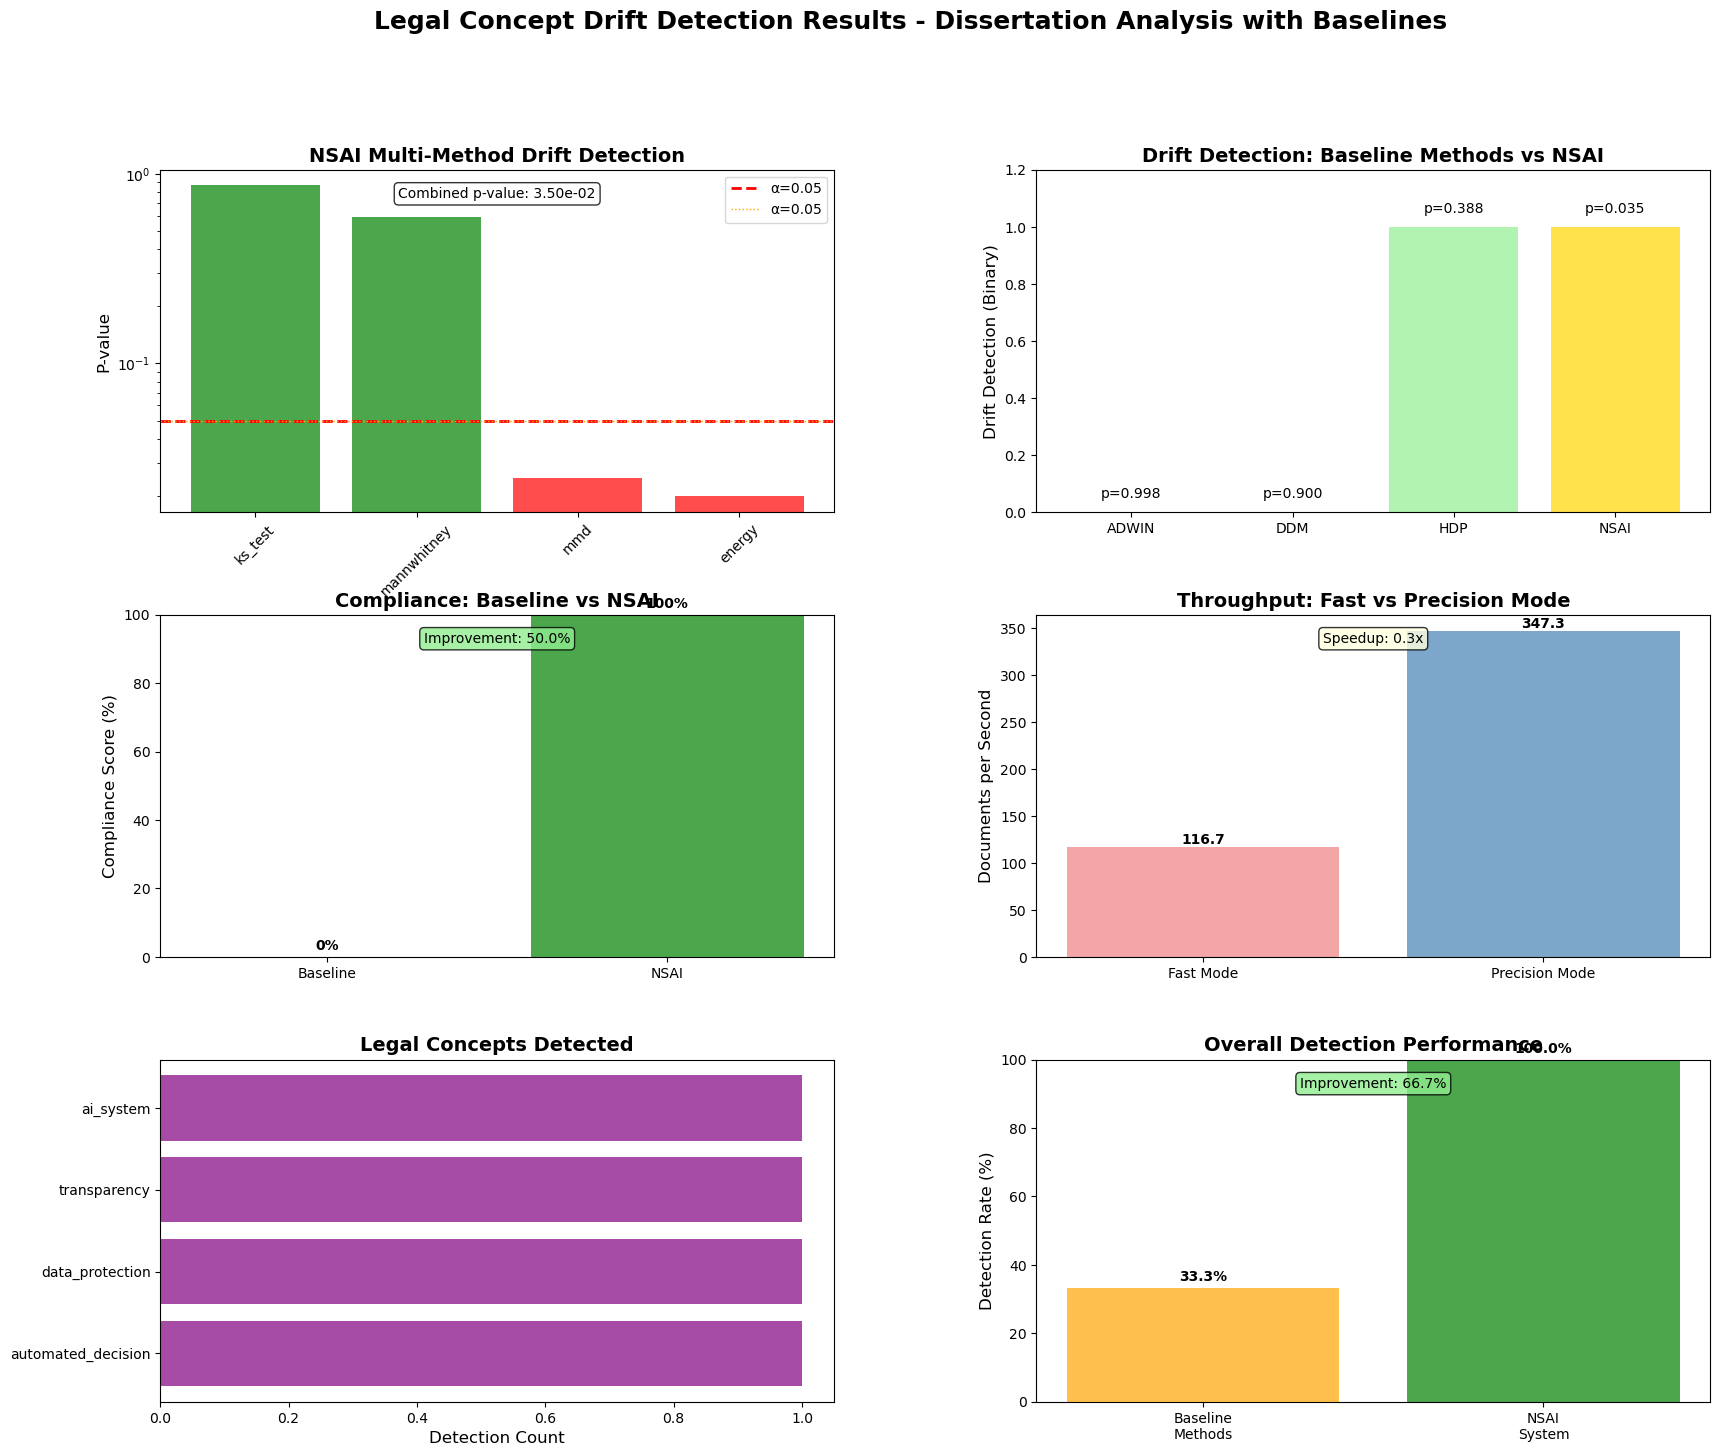


Detailed Technical Analysis with Baseline Comparisons:
##################################################
NSAI System:
  Combined p-value: 3.50e-02
  Sample sizes: 50 baseline, 50 current
  Drift severity: 0.024 (Wasserstein distance)
  Effect size: -0.123 (Cohen's d)

Baseline Methods (Precision Mode):
  ADWIN: drift=False, p=0.998, severity=0.000
  DDM: drift=False, p=0.900, severity=0.000
  HDP: drift=True, p=0.388, severity=1.456

Throughput Metrics:
  Fast mode: 116.7 docs/sec
  Precision mode: 347.3 docs/sec
  Speedup factor: 0.3x

Coverage Improvement:
  NSAI vs Baseline Methods: 66.7%

System Configuration:
  Embedding model: nlpaueb/legal-bert-base-uncased
  Data source: CUAD
  Drift threshold: 0.05


In [14]:

try:
    if 'results' in locals() and 'error' not in results:
        fig = plt.figure(figsize=(20, 16))
        fig.suptitle('Legal Concept Drift Detection Results - Dissertation Analysis with Baselines', fontsize=18, fontweight='bold')

        # Create 2x3 grid for 6 plots
        gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax3 = fig.add_subplot(gs[1, 0])
        ax4 = fig.add_subplot(gs[1, 1])
        ax5 = fig.add_subplot(gs[2, 0])
        ax6 = fig.add_subplot(gs[2, 1])

        # 1. Statistical test results comparison (NSAI)
        tests = list(results['drift_analysis']['statistical_tests'].keys())
        p_values = []
        for test in tests:
            test_data = results['drift_analysis']['statistical_tests'][test]
            p_val = test_data.get('p_value', 0.5)
            p_values.append(p_val)

        threshold = results['drift_analysis']['threshold_used']
        colors = ['red' if p < threshold else 'orange' if p < 0.1 else 'green' for p in p_values]
        bars1 = ax1.bar(tests, p_values, color=colors, alpha=0.7)
        ax1.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'α={threshold}')
        ax1.axhline(y=0.05, color='orange', linestyle=':', linewidth=1, label='α=0.05')
        ax1.set_ylabel('P-value', fontsize=12)
        ax1.set_title('NSAI Multi-Method Drift Detection', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.tick_params(axis='x', rotation=45)
        ax1.set_yscale('log')

        combined_p = results['drift_analysis']['p_value']
        ax1.text(0.5, 0.95, f'Combined p-value: {combined_p:.2e}',
                transform=ax1.transAxes, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # 2. Baseline method comparison
        if 'baselines' in results:
            baseline_methods = list(results['baselines']['precision_mode']['results'].keys())
            baseline_methods.append('NSAI')
            
            detection_results = []
            p_value_results = []
            
            for method in baseline_methods[:-1]:  # Exclude NSAI for now
                method_result = results['baselines']['precision_mode']['results'][method]
                detection_results.append(1 if method_result['drift_detected'] else 0)
                p_value_results.append(method_result['p_value'])
            
            # Adding NSAI results
            detection_results.append(1 if results['drift_analysis']['drift_detected'] else 0)
            p_value_results.append(results['drift_analysis']['p_value'])
            
            colors2 = ['lightblue', 'lightcoral', 'lightgreen', 'gold']
            bars2 = ax2.bar(baseline_methods, detection_results, color=colors2, alpha=0.7)
            ax2.set_ylabel('Drift Detection (Binary)', fontsize=12)
            ax2.set_title('Drift Detection: Baseline Methods vs NSAI', fontsize=14, fontweight='bold')
            ax2.set_ylim(0, 1.2)
            
            # Adding p-value annotations
            for i, (method, p_val) in enumerate(zip(baseline_methods, p_value_results)):
                ax2.text(i, detection_results[i] + 0.05, f'p={p_val:.3f}', ha='center', fontsize=10)

        # 3. Decision comparison (baseline vs NSAI)
        decisions = ['Baseline', 'NSAI']
        baseline_compliance = 0.0 if results['decisions']['baseline']['decision'] == 'ALLOW' else 50.0
        nsai_compliance = 100.0 if results['decisions']['nsai_supervised']['decision'] != 'ALLOW' else 50.0
        compliance_scores = [baseline_compliance, nsai_compliance]

        bars3 = ax3.bar(decisions, compliance_scores, color=['red', 'green'], alpha=0.7)
        ax3.set_ylabel('Compliance Score (%)', fontsize=12)
        ax3.set_title('Compliance: Baseline vs NSAI', fontsize=14, fontweight='bold')
        ax3.set_ylim(0, 100)

        for i, (decision, score) in enumerate(zip(decisions, compliance_scores)):
            ax3.text(i, score + 2, f'{score:.0f}%', ha='center', fontweight='bold')

        improvement = results['performance_metrics']['compliance_improvement_percentage']
        ax3.text(0.5, 0.95, f'Improvement: {improvement:.1f}%',
                transform=ax3.transAxes, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

        # 4. Throughput comparison (Fast vs Precision mode)
        if 'baselines' in results and 'throughput_comparison' in results['performance_metrics']:
            modes = ['Fast Mode', 'Precision Mode']
            throughput_values = [
                results['baselines']['fast_mode']['throughput']['docs_per_second'],
                results['baselines']['precision_mode']['throughput']['docs_per_second']
            ]
            
            bars4 = ax4.bar(modes, throughput_values, color=['lightcoral', 'steelblue'], alpha=0.7)
            ax4.set_ylabel('Documents per Second', fontsize=12)
            ax4.set_title('Throughput: Fast vs Precision Mode', fontsize=14, fontweight='bold')
            
            # Add value labels
            for i, (mode, value) in enumerate(zip(modes, throughput_values)):
                ax4.text(i, value + max(throughput_values) * 0.01, f'{value:.1f}', ha='center', fontweight='bold')
                
            speedup = results['performance_metrics']['throughput_comparison']['speedup_factor']
            ax4.text(0.5, 0.95, f'Speedup: {speedup:.1f}x',
                    transform=ax4.transAxes, ha='center', va='top',
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

        # 5. Legal concepts detection
        concepts = results['legal_concepts']['extracted_concepts'][:6]  # Top 6 for readability
        if concepts:
            concept_counts = [1] * len(concepts)  # Simplified representation
            bars5 = ax5.barh(concepts, concept_counts, color='purple', alpha=0.7)
            ax5.set_xlabel('Detection Count', fontsize=12)
            ax5.set_title('Legal Concepts Detected', fontsize=14, fontweight='bold')
        else:
            ax5.text(0.5, 0.5, 'No legal concepts detected', ha='center', va='center',
                    transform=ax5.transAxes, fontsize=12)
            ax5.set_title('Legal Concepts Detected', fontsize=14, fontweight='bold')

        # 6. Baseline comparison summary metrics
        if 'baselines' in results and 'comparison_metrics' in results['baselines']:
            methods = ['Baseline\nMethods', 'NSAI\nSystem']
            detection_rates = [
                results['baselines']['comparison_metrics']['baseline_methods_detection_rate'] * 100,
                results['baselines']['comparison_metrics']['nsai_detection_rate'] * 100
            ]
            
            bars6 = ax6.bar(methods, detection_rates, color=['orange', 'green'], alpha=0.7)
            ax6.set_ylabel('Detection Rate (%)', fontsize=12)
            ax6.set_title('Overall Detection Performance', fontsize=14, fontweight='bold')
            ax6.set_ylim(0, 100)
            
            for i, (method, rate) in enumerate(zip(methods, detection_rates)):
                ax6.text(i, rate + 2, f'{rate:.1f}%', ha='center', fontweight='bold')
                
            improvement = results['baselines']['comparison_metrics']['nsai_vs_methods_improvement_pct']
            ax6.text(0.5, 0.95, f'Improvement: {improvement:.1f}%',
                    transform=ax6.transAxes, ha='center', va='top',
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

        plt.tight_layout()
        plt.show()

        # Analysis output with baseline comparisons
        print("\nDetailed Technical Analysis with Baseline Comparisons:")
        print("#"*50)
        print(f"NSAI System:")
        print(f"  Combined p-value: {results['drift_analysis']['p_value']:.2e}")
        print(f"  Sample sizes: {results['drift_analysis']['baseline_size']} baseline, {results['drift_analysis']['current_size']} current")
        
        severity = results['drift_analysis'].get('severity', 0.0)
        effect_size = results['drift_analysis'].get('effect_size', 0.0)
        print(f"  Drift severity: {severity:.3f} (Wasserstein distance)")
        print(f"  Effect size: {effect_size:.3f} (Cohen's d)")

        if 'baselines' in results:
            print(f"\nBaseline Methods (Precision Mode):")
            for method, result in results['baselines']['precision_mode']['results'].items():
                print(f"  {method}: drift={result['drift_detected']}, p={result['p_value']:.3f}, severity={result['severity']:.3f}")
            
            print(f"\nThroughput Metrics:")
            fast_throughput = results['baselines']['fast_mode']['throughput']['docs_per_second']
            precision_throughput = results['baselines']['precision_mode']['throughput']['docs_per_second']
            print(f"  Fast mode: {fast_throughput:.1f} docs/sec")
            print(f"  Precision mode: {precision_throughput:.1f} docs/sec")
            print(f"  Speedup factor: {fast_throughput/precision_throughput:.1f}x" if precision_throughput > 0 else "  Speedup factor: N/A")
            
            print(f"\nCoverage Improvement:")
            nsai_vs_methods = results['baselines']['comparison_metrics']['nsai_vs_methods_improvement_pct']
            print(f"  NSAI vs Baseline Methods: {nsai_vs_methods:.1f}%")

        embedding_model = results['metadata']['embedding_model']
        data_source = results['metadata']['data_source']
        print(f"\nSystem Configuration:")
        print(f"  Embedding model: {embedding_model}")
        print(f"  Data source: {data_source}")
        print(f"  Drift threshold: {results['drift_analysis']['threshold_used']}")

    else:
        print("Visualization skipped")
        
except Exception as viz_error:
    log.error("Visualization failed: %s", viz_error)
    print(f"Visualization error: {viz_error}")

# References and code libraries

Wolf, T., Debut, L., Sanh, V., Chaumond, J., Delangue, C., Moi, A., … & Rush, A. M. (2020). Transformers: State-of-the-art natural language processing. Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing: System Demonstrations, 38–45. arXiv:1910.03771


Reimers, N., & Gurevych, I. (2019). Sentence-BERT: Sentence embeddings using Siamese BERT-networks. Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing. Association for Computational Linguistics. GitHub: UKPLab/sentence-transformers

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., … & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825–2830. JMLR


Virtanen, P., Gommers, R., Oliphant, T. E., Haberland, M., Reddy, T., Cournapeau, D., … & SciPy 1.0 Contributors. (2020). SciPy 1.0: Fundamental algorithms for scientific computing in Python. Nature Methods, 17(3), 261–272. Nature Methods


Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., … & Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362. Nature

Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90–95. IEEE

McKinney, W. (2010). Data structures for statistical computing in Python. Proceedings of the 9th Python in Science Conference (SciPy 2010), 56–61. pandas-dev/pandas